# 環境構築

### GPU&バージョン確認

GPUインスタンスに接続できているかを確認します．接続できれば、“GPUゲットだぜ！”と表示

In [1]:
import tensorflow as tf

if tf.test.gpu_device_name() == "/device:GPU:0":
  print("GPUゲットだぜ！")
else:
  print("逃した…")

print("TensorFlow:", tf.__version__)

逃した…
TensorFlow: 2.8.0


In [2]:
#ドライブをマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### データセットの読み込み

画像データは255で割ることにより値が0.0-1.0に収まるように変換します．

ラベルデータは，One-Hot形式に変換します．

In [3]:
#カレントディレクトリに移動
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [4]:
import os
import cv2
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


#フォルダをクラス名にする
path_1 = "img/training"
path_2 = "img/testing"
folders = os.listdir(path_1)

#フォルダ名を抽出
classes = [f for f in folders if os.path.isdir(os.path.join(path_1, f))]
n_classes = len(classes)


#画像とラベルの格納
X_train = []
Y_train = []
X_test = []
Y_test = []

#訓練画像を読み込みリサイズする
for label,class_name in enumerate(classes):
  files = glob.glob(path_1 + "/" +  class_name + "/*")
  for file in files:
    img = cv2.imread(file)
    img = cv2.resize(img,dsize=(224,224))
    X_train.append(img)
    Y_train.append(label)

#精度を上げるために正規化
X_train = np.array(X_train)
X_train = X_train.astype('float32')
X_train /= 255.0

#ラベルの変換
Y_train = np.array(Y_train)
Y_train = np_utils.to_categorical(Y_train,n_classes)
Y_train[:5]

#テスト画像を読み込みリサイズする
for label,class_name in enumerate(classes):
  files = glob.glob(path_2 + "/" +  class_name + "/*")
  for file in files:
    img = cv2.imread(file)
    img = cv2.resize(img,dsize=(224,224))
    X_test.append(img)
    Y_test.append(label)

#精度を上げるために正規化
X_test = np.array(X_test)
X_test = X_test.astype('float32')
X_test /= 255.0

#ラベルの変換
Y_test = np.array(Y_test)
Y_test = np_utils.to_categorical(Y_test,n_classes)
Y_test[:5]

#学習データの数と特徴量
print(X_train.shape)
#テストデータの数と特徴量
print(X_test.shape)
#学習データ数とクラス
print(Y_train.shape)
#テストデータ数とクラス
print(Y_test.shape)

(258, 224, 224, 3)
(50, 224, 224, 3)
(258, 5)
(50, 5)


# VGG16によるファインチューニング



In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#vgg16
input_tensor = Input(shape=(224,224,3))
#最後の1000の層を省く
base_model = VGG16(weights='imagenet', input_tensor=input_tensor,include_top=False)


#後付けで入れたい層の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(n_classes, activation='softmax'))


#結合
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))


#学習させない層
for layer in model.layers[:15]:
  layer.trainable = False

print('# layers=', len(model.layers))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 2s 0us/step
# layers= 20
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                 

In [6]:
#学習データで学習
model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_test, Y_test))

Epoch 1/20
17/17 [==============================] - 186s 11s/step - loss: 2.3702 - accuracy: 0.1977 - val_loss: 1.6380 - val_accuracy: 0.2000
Epoch 2/20
17/17 [==============================] - 183s 11s/step - loss: 1.5738 - accuracy: 0.2791 - val_loss: 1.7773 - val_accuracy: 0.2000
Epoch 3/20
17/17 [==============================] - 184s 11s/step - loss: 1.6322 - accuracy: 0.2752 - val_loss: 1.6691 - val_accuracy: 0.2000
Epoch 4/20
17/17 [==============================] - 183s 11s/step - loss: 1.5644 - accuracy: 0.2868 - val_loss: 1.6695 - val_accuracy: 0.2000
Epoch 5/20
17/17 [==============================] - 183s 11s/step - loss: 1.5586 - accuracy: 0.2791 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 6/20
17/17 [==============================] - 183s 11s/step - loss: 1.6081 - accuracy: 0.1822 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 7/20
17/17 [==============================] - 183s 11s/step - loss: 1.6064 - accuracy: 0.2868 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 

In [7]:
import pickle
#クラス名の保存
pickle.dump(classes, open('classes.sav', 'wb'))
#モデルの保存
model.save('cnn3.h5')

テストデータの所属確率を計算

In [9]:
# テストデータのクラスへの所属確率
a_pred_P = model.predict(X_test, batch_size=128, verbose=1)
# テストデータの所属クラスID(0-4)
classes_x = np.argmax(a_pred_P,axis=1)
print(classes_x)
# テストデータのクラスへの所属確率をNumPy形式で保存
np.save('Potato-Feature-Pred.npy', a_pred_P)
# DNN特徴量で訓練したニューラルネットワークでの平均分類精度の計算
accuracy = model.evaluate(X_test, Y_test, batch_size=128, verbose=1)
print('分類精度:DNN(VGG16) = {:.4f}'.format(accuracy[1]))

1/1 [==============================] - 27s 27s/step
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
1/1 [==============================] - 25s 25s/step - loss: 1.6132 - accuracy: 0.2000
分類精度:DNN(VGG16) = 0.2000


In [10]:
# Matplotlibのフォントの制御（大きさや種類）
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix_vgg(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('predicted value',fontsize=25)
    plt.xlabel('true value',fontsize=25)
    plt.savefig('potato-vgg-ConfusionMatrix_FT.jpg')
    plt.savefig('potato-vgg-ConfusionMatrix_FT.pdf')

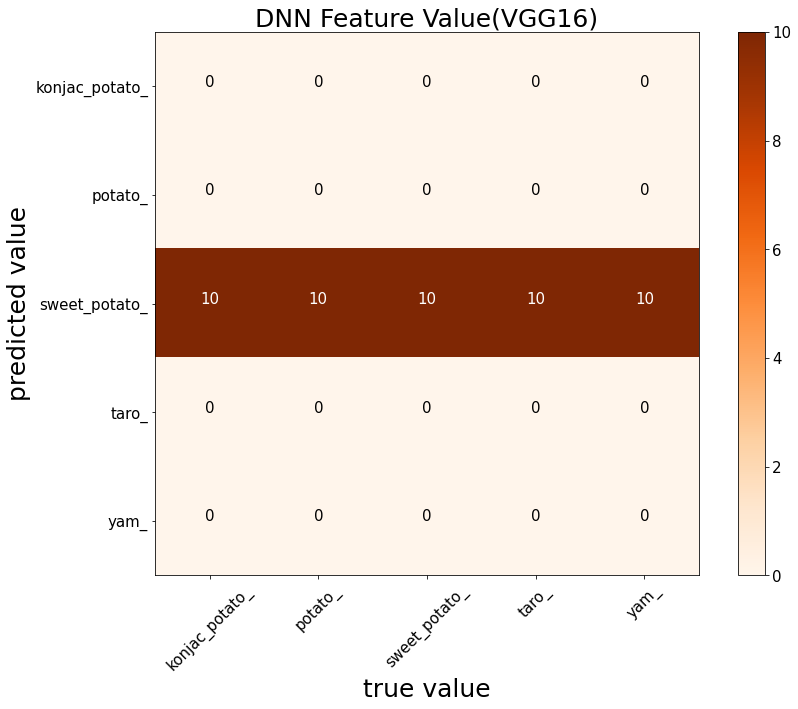

In [12]:
# ファインチューニングで訓練したニューラルネットワークでの予測手法の混合行列計算と描画
test_truth = np.argmax(Y_test,axis=1)
a_cm = confusion_matrix(classes_x, test_truth) 
plot_confusion_matrix_vgg(a_cm, classes=classes, title='DNN Feature Value(VGG16)')
plt.show() 